# Mecab  Download

In [2]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 


Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 1.21 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [3]:
cd Mecab-ko-for-Google-Colab


/content/Mecab-ko-for-Google-Colab


In [4]:
!bash install_mecab-ko_on_colab_light_220429.sh

Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 12.6 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-04-25 04:33:58--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=

# Mount and Library import

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/hate_discrimination_nlp

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/hate_discrimination_nlp


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB



import torch.nn as nn
import torch.optim as optim


# Data 가져오기

In [7]:
df = pd.read_csv('./train.csv', encoding='utf-8')
df.head()


,ID,text,label
0,0,유소영비호감 성형아줌마,1
1,1,나오지마라 썅,3
2,2,식상하고 지긋지긋했는데 잘 끝나네 오예 소리벗고 빤스질러~~!!!,6
3,3,성희롱 당할 얼굴이 아닌데?ㅋㅋㅋ,5
4,4,"""끝까지 해보자~쪽파리 원숭이 자한 쓰레기당""",0


### class distribution

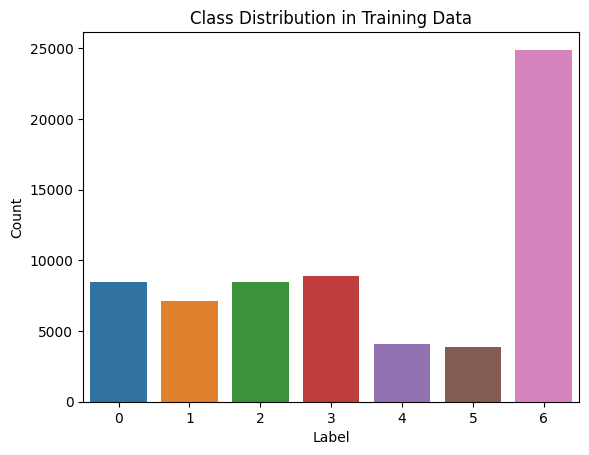

In [ ]:

# Plot the class distribution
sns.countplot(x='label', data=df)

# Add labels to the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')

# Show the plot
plt.show()

In [ ]:
df['label'].value_counts()

6    24900
3     8895
2     8481
0     8463
1     7107
4     4118
5     3899
Name: label, dtype: int64

### Get the length of each sentence

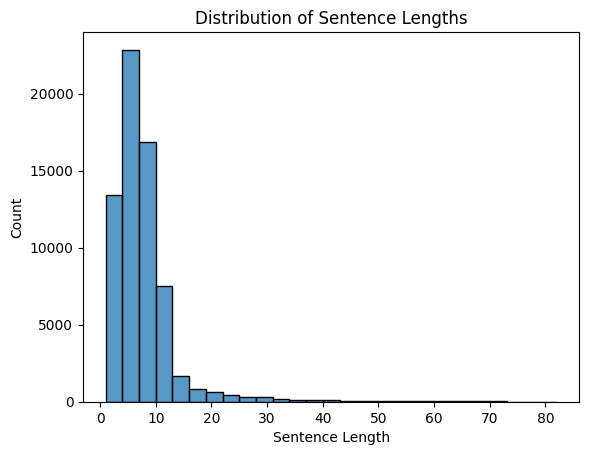

In [ ]:
# Get the length of each sentence
sentence_lengths = df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
sns.histplot(data=sentence_lengths, binwidth=3)

# Add labels to the plot
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

# **(Pytorch)** Tokenization  and preprocessing

In [14]:
# Split your data into training and testing sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the text using Mecab
tokenizer = Mecab()
train_tokenized_text = df_train['text'].apply(lambda x: ' '.join(tokenizer.morphs(x)))
val_tokenized_text = df_val['text'].apply(lambda x: ' '.join(tokenizer.morphs(x)))

# Convert the tokens into a bag-of-words representation
vectorizer = CountVectorizer(max_features=100000)
X_train = vectorizer.fit_transform(train_tokenized_text)
X_val = vectorizer.transform(val_tokenized_text)



# 전처리 2222
selector = SelectKBest(chi2, k=10000)
X_train = selector.fit_transform(X_train, df_train['label'])
X_val = selector.transform(X_val)



import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create train and validation datasets
train_dataset = TextDataset(X_train.toarray(), df_train['label'].values)
val_dataset = TextDataset(X_val.toarray(), df_val['label'].values)

# Create train and validation data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)




# **(Pytorch)** Model training

In [16]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Define the model architecture
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



# Define the training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    train_f1 = 0
    for X, y in train_loader:
        X = X.to(device)
        y = F.one_hot(y, num_classes=7).float().to(device)

        optimizer.zero_grad()

        outputs = model(X.float())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        train_f1 += f1_score(y.cpu().detach().numpy(), preds.cpu().detach().numpy(), average='samples')

    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)
    return train_loss, train_f1

# Define the validation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_f1 = 0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = F.one_hot(y, num_classes=7).float().to(device)

            outputs = model(X.float())
            loss = criterion(outputs, y)

            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            val_f1 += f1_score(y.cpu().detach().numpy(), preds.cpu().detach().numpy(), average='samples')

        val_loss /= len(val_loader)
        val_f1 /= len(val_loader)
    return val_loss, val_f1


# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(df_train['label'].unique())
model = TextClassifier(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1 = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}")



Epoch 1/10, Train Loss: 0.3001, Train F1: 0.2215, Validation Loss: 0.2334, Validation F1: 0.3874
Epoch 2/10, Train Loss: 0.2021, Train F1: 0.4940, Validation Loss: 0.2280, Validation F1: 0.4540
Epoch 3/10, Train Loss: 0.1756, Train F1: 0.5795, Validation Loss: 0.2340, Validation F1: 0.4954
Epoch 4/10, Train Loss: 0.1579, Train F1: 0.6319, Validation Loss: 0.2419, Validation F1: 0.5143
Epoch 5/10, Train Loss: 0.1441, Train F1: 0.6699, Validation Loss: 0.2525, Validation F1: 0.5202
Epoch 6/10, Train Loss: 0.1325, Train F1: 0.7005, Validation Loss: 0.2639, Validation F1: 0.5265
Epoch 7/10, Train Loss: 0.1221, Train F1: 0.7254, Validation Loss: 0.2746, Validation F1: 0.5277
Epoch 8/10, Train Loss: 0.1127, Train F1: 0.7477, Validation Loss: 0.2875, Validation F1: 0.5273
Epoch 9/10, Train Loss: 0.1039, Train F1: 0.7689, Validation Loss: 0.3030, Validation F1: 0.5276
Epoch 10/10, Train Loss: 0.0954, Train F1: 0.7908, Validation Loss: 0.3197, Validation F1: 0.5352


# **(MultinomialNB)**Tokenization and Data processing

In [10]:
# Split your data into training and testing sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

y_train = df_train['label']
y_val = df_val['label']

# Tokenize the text using Mecab
tokenizer = Mecab()
train_tokenized_text = df_train['text'].apply(lambda x: ' '.join(tokenizer.morphs(x)))
val_tokenized_text = df_val['text'].apply(lambda x: ' '.join(tokenizer.morphs(x)))

# Convert the tokens into a bag-of-words representation
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_tokenized_text)
X_val = vectorizer.transform(val_tokenized_text)


# 전처리 2222
selector = SelectKBest(chi2, k=1000)
X_train = selector.fit_transform(X_train, df_train['label'])
X_val = selector.transform(X_val)


# **(MultinomialNB)** Model training

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
# Create a MultinomialNB object
nb = MultinomialNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Predict on the validation set
y_pred = nb.predict(X_val)

# Evaluate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Evaluate the f1 score
f1 = f1_score(y_val, y_pred, average='macro')
print(f"F1 score: {f1:.4f}")

Accuracy: 0.6394
F1 score: 0.5854


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5]}

# Create a MultinomialNB object
nb = MultinomialNB()

# Define the scoring function
scorer = make_scorer(f1_score, average='macro')

# Create the grid search object
grid_search = GridSearchCV(nb, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding f1 score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best f1 score: {grid_search.best_score_:.4f}")


Best parameters: {'alpha': 0.3}
Best f1 score: 0.5889


# 제출

In [ ]:
# Convert the images and labels to NumPy arrays
df_test = pd.read_csv('./test.csv', encoding='utf-8')


tokenized_test = df_test['text'].apply(lambda x: ' '.join(tokenizer.morphs(x)))

# Convert the tokens into a bag-of-words representation
X_test = vectorizer.transform(tokenized_test)

X_test_selected = selector.transform(X_test)


# Make predictions on test data using trained model
#y_pred = nb.predict(X_test)


y_pred = nb.predict(X_test_selected)





# Add predictions to test data DataFrame
df_test['label'] = y_pred

# Save test data with predictions to CSV file
df_test.to_csv('./submission.csv', index=False)









